# imports and data loading

In [ ]:
import os
import sys
import hydra
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import submitit
import time
from tqdm import tqdm
from itertools import combinations
from icecream import ic


import seaborn as sns
import matplotlib.pyplot as plt


from preprocessing import moving_average
from causal_discovery_tools import get_link_assumptions, split_list_into_subsets, mask_builder

from tigramite import data_processing as pp
from tigramite.independence_tests.parcorr import ParCorr

# use datatime for dates outside of the pd.datetime bounds
from datetime import datetime

ids = [
    6337610,
    6502171,
    6335046,
    6338200,
    6338160,
    6123710,
    6503851,
    6229100,
    6335351,
    6123350,
    6139682,
    6503280,
    6503500,
    6731600,
    6338120,
    6934571,
    6338161,
    6503855,
    6335160,
    6139790,
    6502151,
    6233350,
    6233100,
    6321100,
    6342521,
    6604220,
    6243400,
    6338150,
    6503281,
    6337504,
    6335045,
    6503201,
    6335081,
    6119200,
    6854590,
    6337050,
    6503180,
    6123160,
    6503351,
    6335360,
    6503301,
    6855409,
    6136200,
    6503300,
    6233520,
  ]


var_names = ["pre", "tavg7", "snow", "SM", "Q"]
pre, tavg, snow, sm, q = 0, 1, 2, 3, 4

In [2]:
# get the basin information as provided by the grdc
grdc_info = pd.read_excel('/data/compoundx/GRDC_runoff/GRDC_Stations.xlsx')
grdc_info = grdc_info.rename(columns={"grdc_no": "id"})
grdc_info = grdc_info.set_index("id")


# read the data
data_base_path = '/data/compoundx/causal_flood/stability_testing/data/'
all_peaks = {}
all_data = {}
for dataset_context in tqdm(['observed','simulated','resampled']):
    data_path = os.path.join(data_base_path,dataset_context)
    all_peaks[dataset_context] = {}
    all_data[dataset_context] = {}
    for id in tqdm(ids):
        peak_indices = []
        with open(os.path.join(data_path, f'{id}_peak_indices_USWRC.txt'), 'r') as filehandle:
            peak_indices = [current_place.rstrip() for current_place in filehandle.readlines()]
        peak_indices = list(map(int, peak_indices))
        all_peaks[dataset_context][id] = [int(p)for p in peak_indices]
        data = pd.read_csv(os.path.join(data_path, f'{id}.csv'))
        data['time'] = data['time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
        data["tavg7"] = moving_average(data["tavg"], 7)
        # data = data.set_index('time')
        data = data[["pre", "tavg7", "snow", "SM", "Q"]]
        all_data[dataset_context][id] = data

100%|██████████| 3/3 [01:56<00:00, 38.80s/it]


In [ ]:
all_data['resampled'][ids[1]]

,pre,tavg7,snow,SM,Q
0,4.712180,5.566819,3.781204,0.398806,10.531470
1,3.858443,5.539686,0.000000,0.418422,13.800624
2,1.650717,6.169430,0.000000,0.424670,13.339023
3,0.069718,6.887132,0.000000,0.426324,12.897436
4,8.687705,7.642578,0.000000,0.437056,12.489040
...,...,...,...,...,...
364995,0.000000,5.062363,0.000000,0.995763,19.225879
364996,0.000000,3.311259,0.000000,0.993444,18.200880
364997,0.000000,2.480128,0.000000,0.990923,17.317625
364998,0.000000,1.666181,0.000000,0.988278,16.490907


# run analysis with ParCorr

In [4]:
def run_single_cond_ind_test(cond_ind_test, X, Y, Z, alpha):
    test_statistic, p_value, dependent = cond_ind_test.run_test(
        X=X, 
        Y=Y,
        Z=Z,
        alpha_or_thres = alpha
        )
    # print(f"P-value for conditional independence: {p_value}")
    return test_statistic, p_value, dependent

def get_statistics_unconditional_independence(cond_ind_test, X, Ys, alpha):
    results = []  # List to store (Y, test_statistic, p_value) tuples
    for Y in Ys:
        # ic(Y)
        test_statistic, p_value, dependent = cond_ind_test.run_test(X= X, Y = [Y], Z = None,  alpha_or_thres = alpha)
        results.append((Y, abs(test_statistic), p_value, dependent))
    # Sort the results by test_statistic in descending order
    results.sort(key=lambda x: x[1], reverse=True)

    return results

def all_combinations(unique_objects):
    result = []
    for r in range(1, len(unique_objects) + 1):  # r is the length of the combination
        result.extend(list(combinations(unique_objects, r)))
    return [list(comb) for comb in result]


def run_all_combinations_cond_ind_tests(cond_ind_test, X, Y, all_parents, alpha):
    Zs = all_combinations(all_parents)
    results = []
    for Z in Zs:
        test_statistic, p_value, dependent = run_single_cond_ind_test(cond_ind_test=cond_ind_test, X= X, Y = Y, Z = Z, alpha=alpha)
        results.append((Z, test_statistic, p_value, dependent))
    return(results)

def run_increasing_order_cond_ind_tests(cond_ind_test, X,Y, all_parents, alpha):
    # get the parents of X unconditional independence test statistic
    statistical_test_ordered_results = get_statistics_unconditional_independence(cond_ind_test=cond_ind_test, X = X, Ys = all_parents, alpha=alpha)
    # convert to list
    # remove Y from the list as it should not be used in the conditioning set
    all_parents_ordered = [l[0] for l in statistical_test_ordered_results if l[0] != Y[0]]
    # iterate through increasing size of conditioning set
    results_df = pd.DataFrame(columns=['cond_size', 'cond_set', 'test_statistic', 'p_value', 'dependent'])
    for cond_size in range(0,len(all_parents_ordered)):
        cond_set = all_parents_ordered[0:cond_size]
        test_statistic, p_value, dependent = run_single_cond_ind_test(cond_ind_test=cond_ind_test, X= X, Y = Y, Z = cond_set, alpha=alpha)
        row = {
        'cond_size': cond_size,
        'cond_set': cond_set,
        'test_statistic': test_statistic,
        'p_value': p_value,
        'dependent': int(dependent)
        }
        results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)

    return results_df


def run_increasing_order_cond_ind_tests_folds(cond_ind_test, X,Y, alpha, data, peaks, max_folds, subset_size, output_file = None):
    # calculate the maximum number of folds possible given the number of peaks and the fold size
    max_folds_possible = len(peaks) // subset_size
    folds_used = min(max_folds,max_folds_possible)
    # create the folds
    folds_peak = split_list_into_subsets(
                    data=peaks,
                    num_subsets=folds_used,
                    subset_size=1000,
                    random_seed=1337,
                )
    basin_results = pd.DataFrame()
    # iterate through folds
    for fold_index in range(folds_used):
        # create the mask with the fold indices
        mask = mask_builder(data= data, indices=folds_peak[fold_index])

        # initilize dataframe and cond_ind_test
        dataframe = pp.DataFrame(data.to_numpy(), var_names=data.columns.to_list(), mask = mask)
        cond_ind_test.set_dataframe(dataframe)
        cond_ind_test.set_mask_type('y')
        # get all parents of q
        parents_of_q = list(get_link_assumptions()[4].keys())

        # get results for single fold
        results_fold = run_increasing_order_cond_ind_tests(cond_ind_test=cond_ind_test,
                                            X = X,
                                            Y = Y,
                                            all_parents=parents_of_q,
                                            alpha=alpha,
                                            )
        results_fold['fold'] = fold_index
        # concate the results into a single dataframe
        basin_results = pd.concat([basin_results, results_fold], ignore_index=True)
    # write out the results to csv
    if output_file is not None:
        basin_results.to_csv(output_file, index=False)
    return basin_results
    

In [5]:
for id in tqdm(ids):
    context = 'resampled'
    ic(id)
    data = all_data[context][id]
    peaks = all_peaks[context][id]

    X = [(q,0)]
    Y = [(pre,-4)]

    single_basin_results = run_increasing_order_cond_ind_tests_folds(cond_ind_test = ParCorr(),
                                            X = X,
                                            Y = Y,
                                                alpha = 0.05,
                                                data = all_data[context][id],
                                                peaks = all_peaks[context][id],
                                                max_folds = 10,
                                                subset_size = 1000,
                                                output_file = os.path.join('/data/compoundx/causal_flood/stability_testing/single_edge_analysis/ParCorr_pre4/', f'{id}.csv'))






  0%|          | 0/45 [00:00<?, ?it/s]

ic| id: 6337610
100%|██████████| 45/45 [03:03<00:00,  4.07s/it]


# analyse results 

## load results

In [2]:
from hydra import initialize, compose
from discovery_result_dataclass import discovery_result
runtype = "production"
with initialize(config_path="conf/io", version_base=None):
    conf = compose(config_name=runtype)

# define basin ids
basin_ids = ids


resampled_files = [file for file in os.listdir(os.path.join(conf['models'], "discovery_resampled")) if file.endswith(".pkl")]

resampled_results = []

for file in tqdm(resampled_files):
    file_path = os.path.join(conf['models'], "discovery_resampled", file)
    result = discovery_result.load_from_disk(file_path=file_path)
    resampled_results.append(result)


100%|██████████| 11259/11259 [12:38<00:00, 14.84it/s]


In [124]:
# results cond_ind_test
results_dict_ParCorr = {}
results_dict_GPDC = {}
edge_of_interest = 'sm'
# load the data into dicts
for id in ids:
    result_ParCorr = pd.read_csv(os.path.join(f'/data/compoundx/causal_flood/stability_testing/single_edge_analysis/ParCorr_{edge_of_interest}/', f'{id}.csv'))
    results_dict_ParCorr[id] = result_ParCorr
    if os.path.exists(os.path.join(f'/data/compoundx/causal_flood/stability_testing/single_edge_analysis/GPDC_{edge_of_interest}/', f'{id}.csv')):
        result_GPDC = pd.read_csv(os.path.join(f'/data/compoundx/causal_flood/stability_testing/single_edge_analysis/GPDC_{edge_of_interest}/', f'{id}.csv'))
        results_dict_GPDC[id] = result_GPDC
    else:
        print(f'Results for {id} {edge_of_interest} for GPDC not found')

# combine the dicts into a single dataframe
results_ParCorr = pd.concat([df.assign(id=id) for id, df in results_dict_ParCorr.items()], ignore_index=True)
results_GPDC = pd.concat([df.assign(id=id) for id, df in results_dict_GPDC.items()], ignore_index=True)

In [125]:
fontsize_title = 18
fontsize_legend = 16
fontsize_ticks = 13
sns.set_style("whitegrid")

def plot_single_edge_analysis_results_basin(results_cond_ind, results_pcmci, title, cause, effect, lag):
    results_pcmci['edge_of_interest'] = results_pcmci['discovery_result'].apply(lambda x: True if x['graph'][sm,q,7] != '' else False)
    fraction_true = results_pcmci.groupby('basin_id')['edge_of_interest'].mean()

    # Convert the result to a DataFrame
    fraction_true_df = fraction_true.reset_index()

    # Rename the columns for clarity
    fraction_true_df.columns = ['id', 'fraction_true']
    
    fraction_of_ones = results_cond_ind.groupby(['cond_size', 'id'])['dependent'].mean().reset_index()

    

    
    return


In [126]:
result_GPDC

,cond_size,cond_set,test_statistic,p_value,dependent,fold
0,0,[],0.382545,0.000,1,0
1,1,"[(4, -1)]",0.153489,0.000,1,0
2,2,"[(4, -1), (1, 0)]",0.110219,0.000,1,0
3,3,"[(4, -1), (1, 0), (2, -7)]",0.078232,0.028,1,0
4,4,"[(4, -1), (1, 0), (2, -7), (0, -1)]",0.175668,0.000,1,0
...,...,...,...,...,...,...
95,5,"[(4, -1), (1, 0), (2, -7), (0, -1), (0, -2)]",0.171598,0.000,1,9
96,6,"[(4, -1), (1, 0), (2, -7), (0, -1), (0, -2), (...",0.157855,0.000,1,9
97,7,"[(4, -1), (1, 0), (2, -7), (0, -1), (0, -2), (...",0.194532,0.000,1,9
98,8,"[(4, -1), (1, 0), (2, -7), (0, -1), (0, -2), (...",0.190157,0.000,1,9


In [ ]:
from dataclasses import asdict
results_pcmci_list = [result for result in resampled_results if result.sample_size == 1000 and result.cond_ind_test == 'GPDC' and result.peaks_used == True]
results_pcmci_list_dict = [asdict(result) for result in results_pcmci_list]

results_pcmci = pd.DataFrame(results_pcmci_list_dict)

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


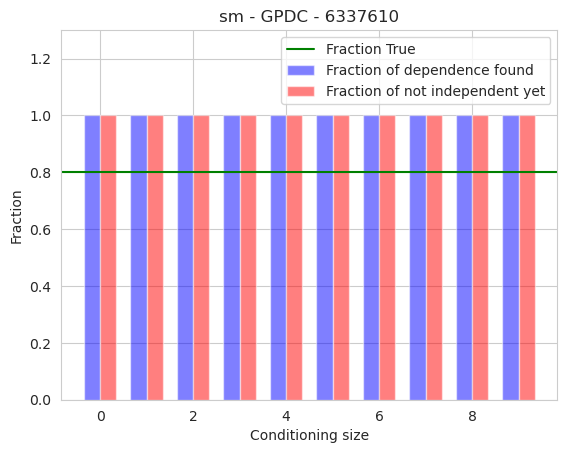

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


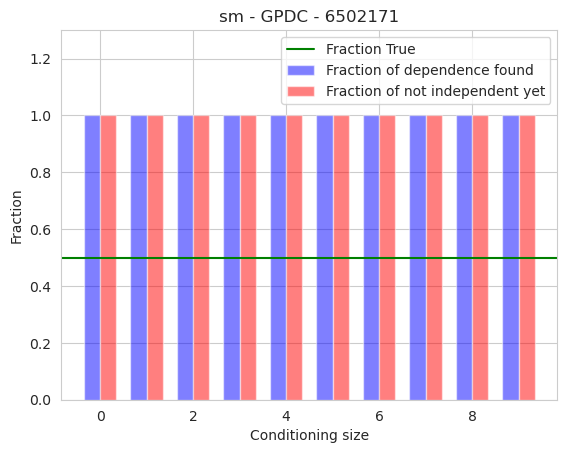

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


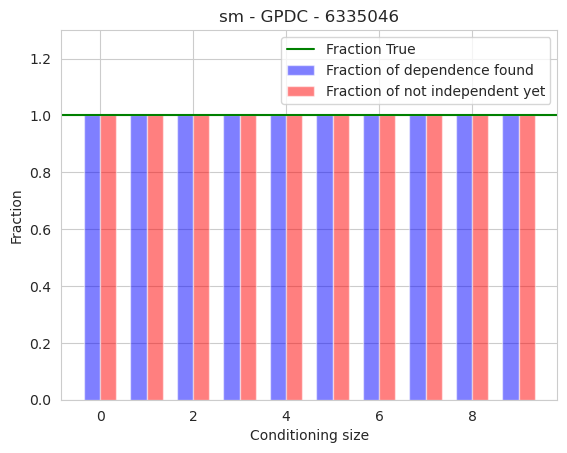

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


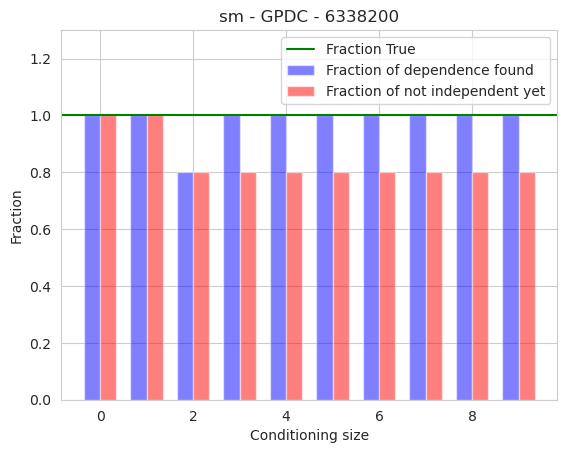

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


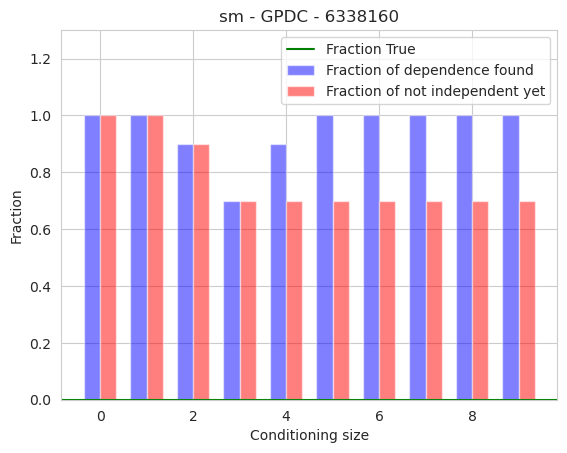

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


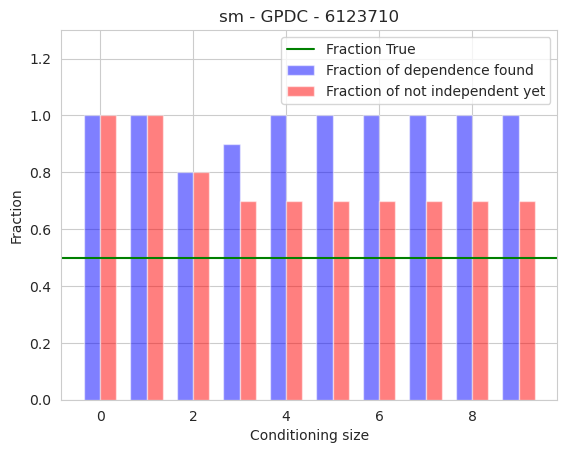

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


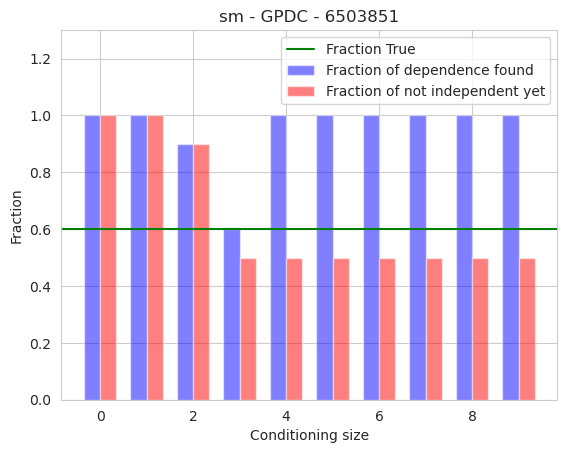

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


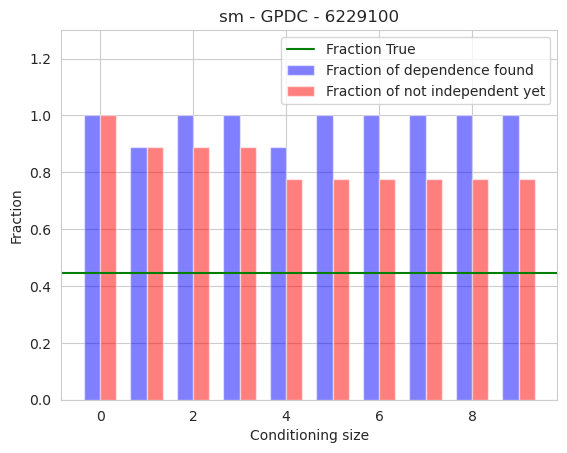

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


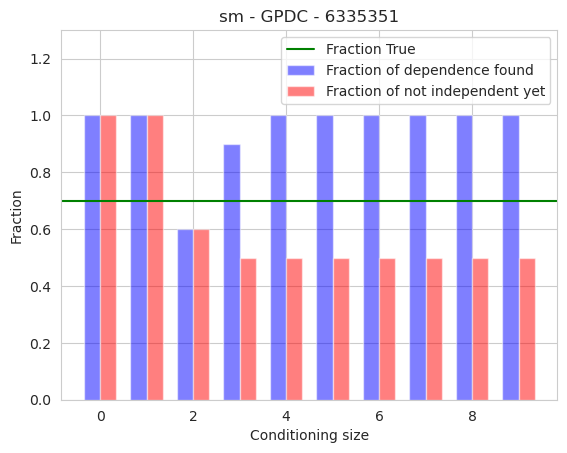

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


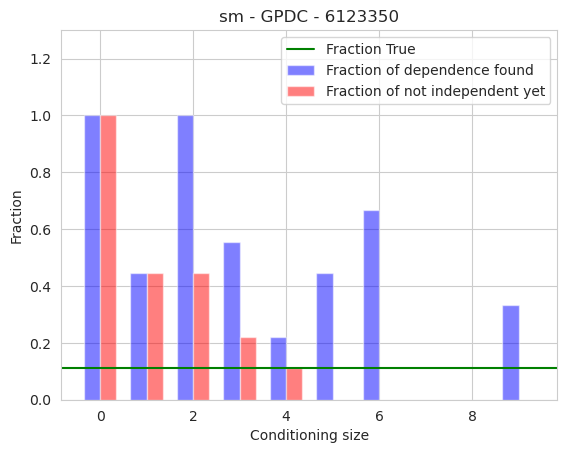

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


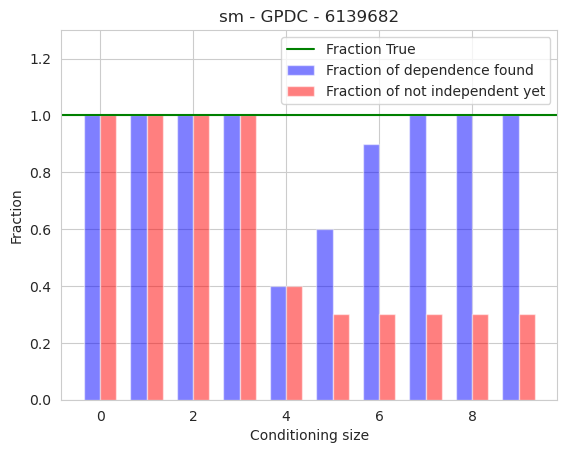

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


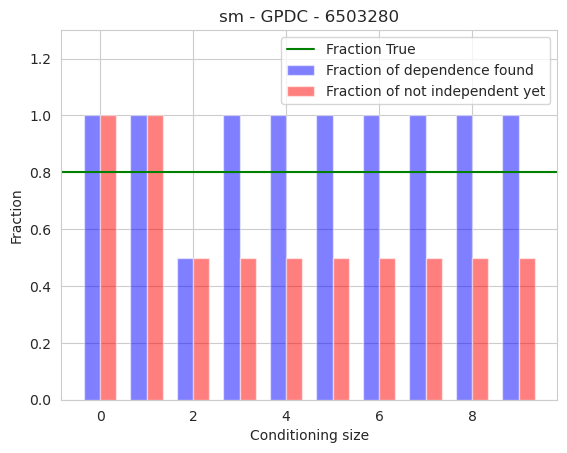

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


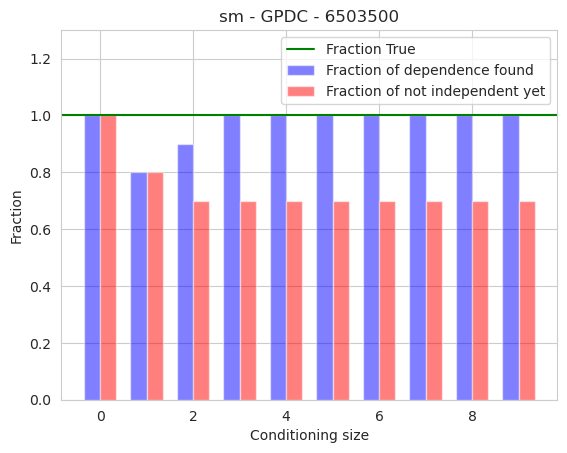

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


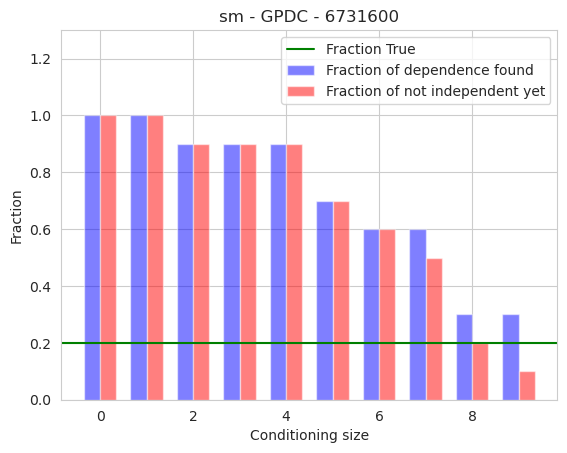

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


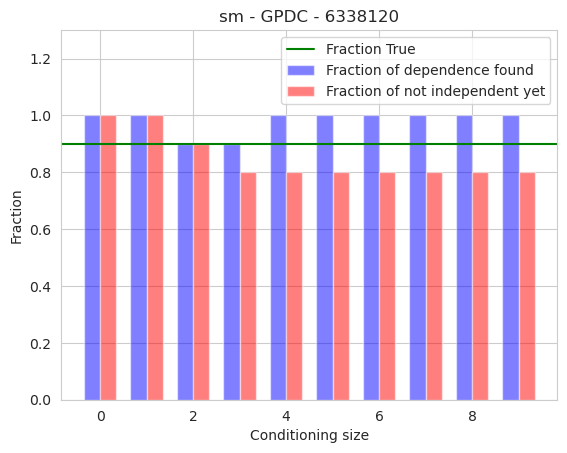

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


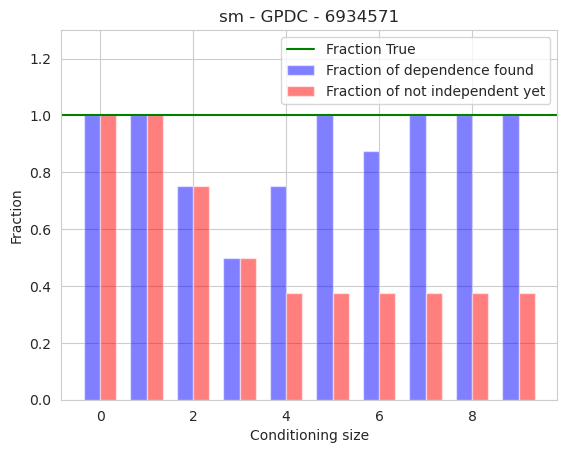

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


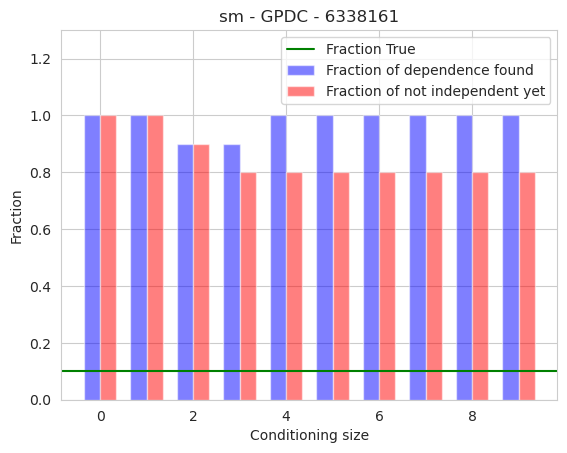

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


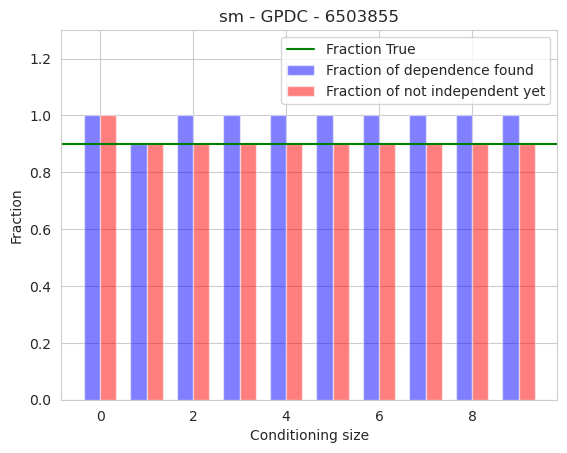

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


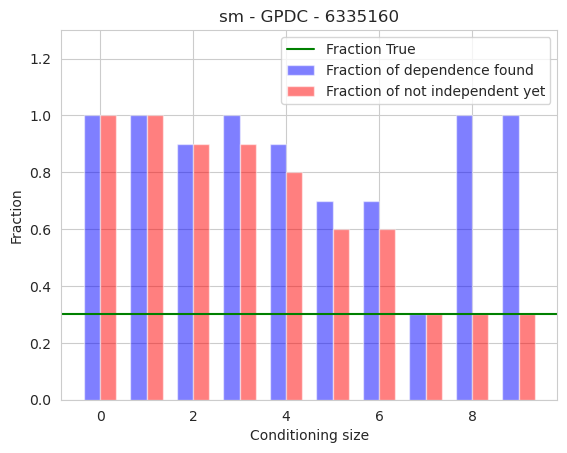

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


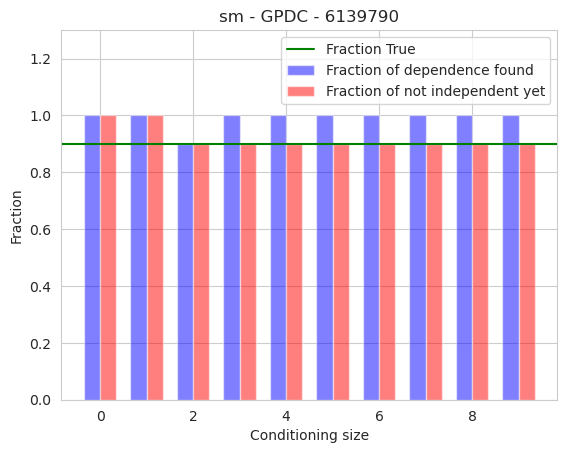

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


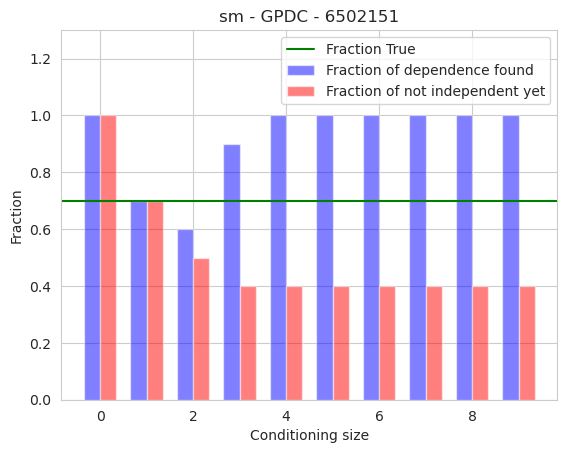

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


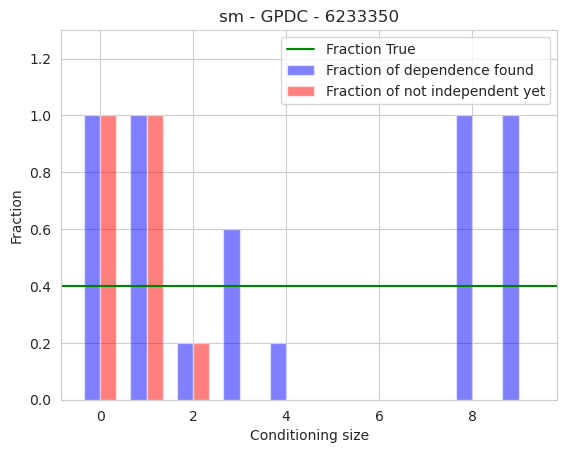

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


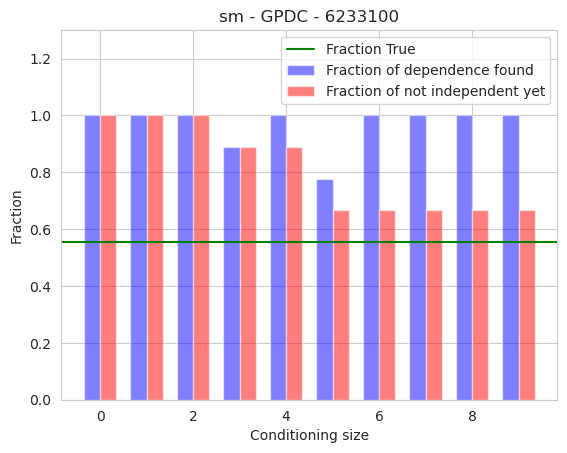

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


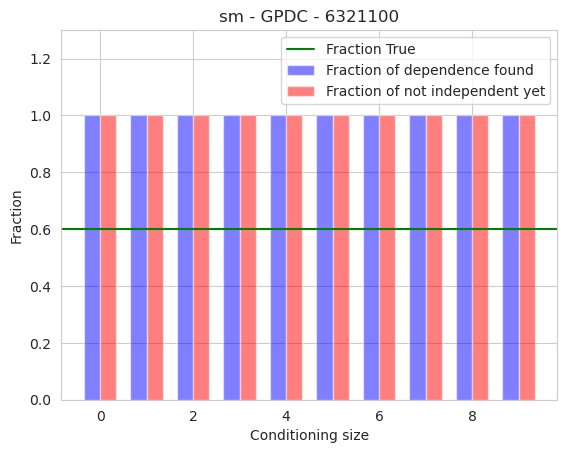

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


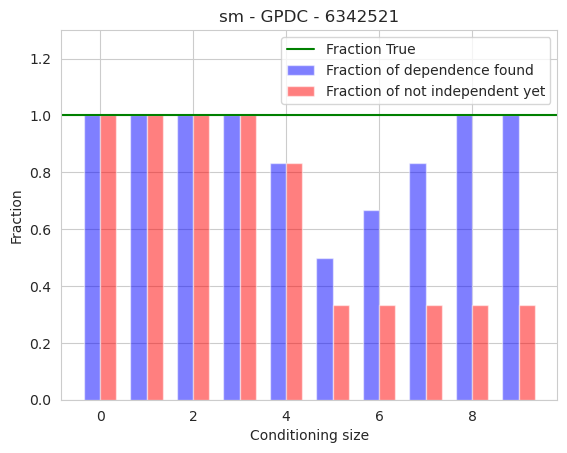

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


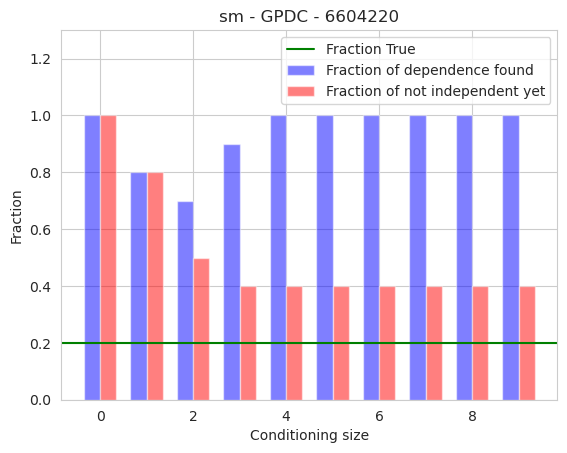

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


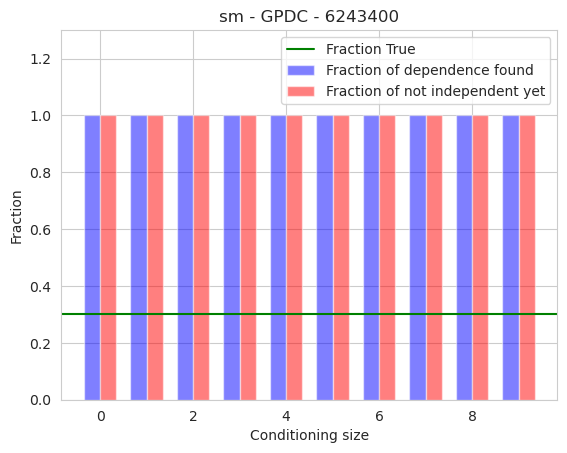

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


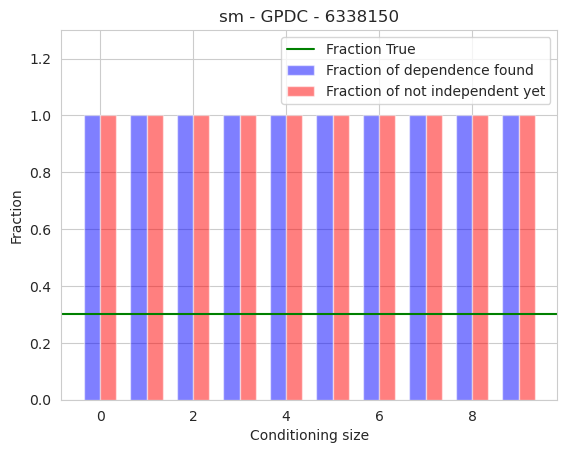

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


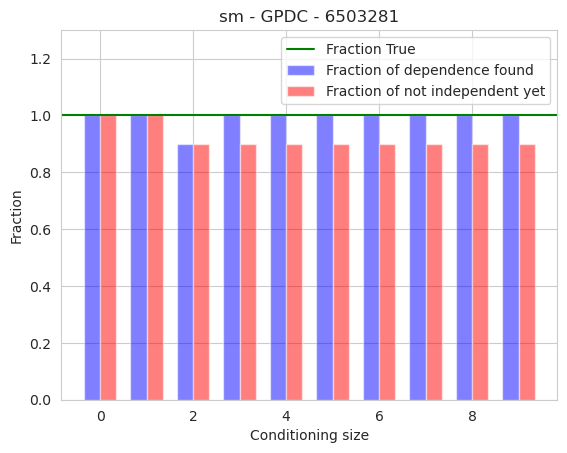

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


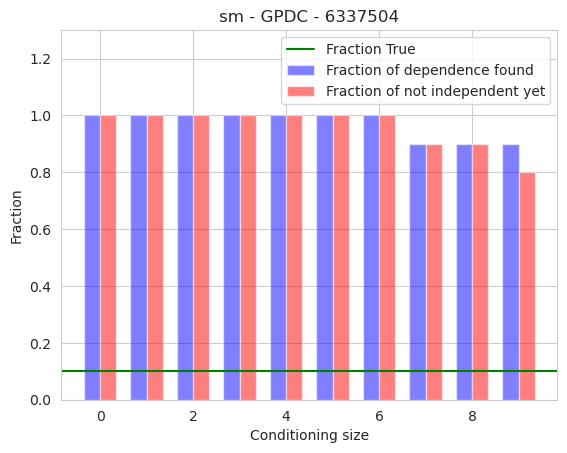

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


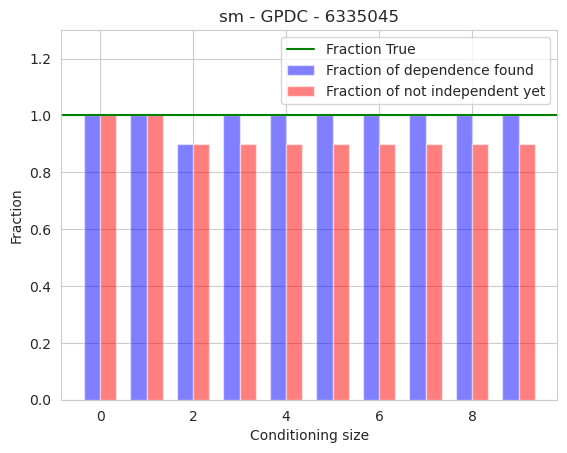

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


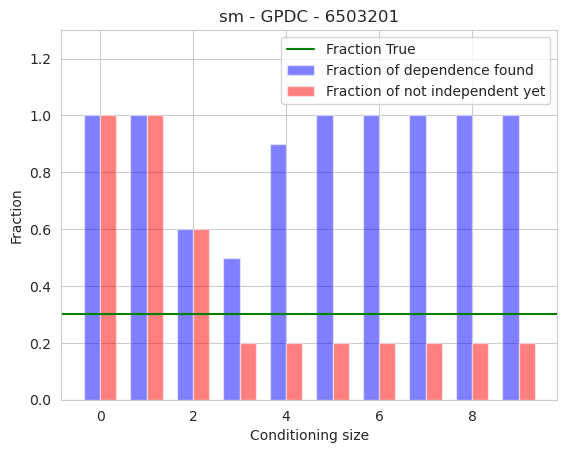

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


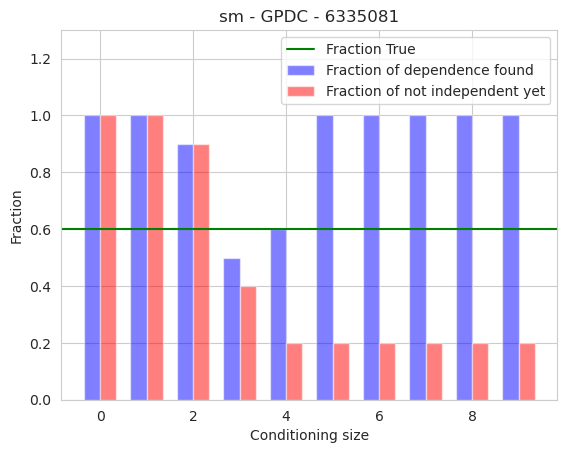

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


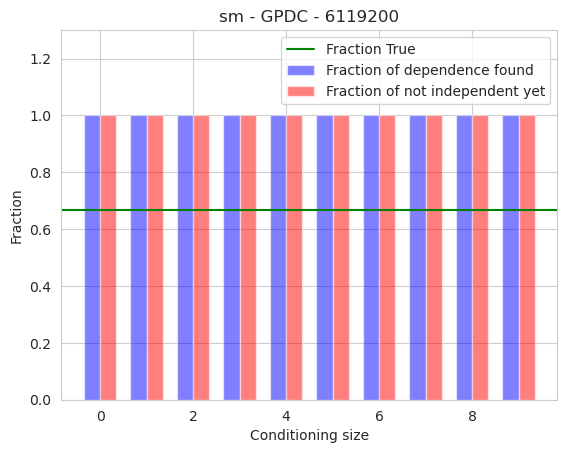

/tmp/ipykernel_3101155/1629477818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)


KeyError: 'discovery_result'

In [141]:
from dataclasses import asdict
test_name = 'GPDC'
for id in ids:
    cause = sm
    lag = 7


    results_cond_ind = results_GPDC[results_GPDC['id'] == id]
    results_cond_ind['id_fold'] = results_cond_ind['id'].astype(str) + '_' + results_cond_ind['fold'].astype(str)

    results_pcmci_list = [result for result in resampled_results if result.sample_size == 1000 and result.cond_ind_test == 'GPDC' and result.peaks_used == True and result.basin_id == id]
    results_pcmci_list_dict = [asdict(result) for result in results_pcmci_list]

    results_pcmci = pd.DataFrame(results_pcmci_list_dict)
    results_pcmci['edge_of_interest'] = results_pcmci['discovery_result'].apply(lambda x: True if x['graph'][cause,q,lag] != '' else False)
    fraction_true = results_pcmci.groupby('basin_id')['edge_of_interest'].mean()

    # Convert the result to a DataFrame
    fraction_true_df = fraction_true.reset_index()

    # Rename the columns for clarity
    fraction_true_df.columns = ['id', 'fraction_true']


    fraction_of_ones = results_cond_ind.groupby(['cond_size', 'id'])['dependent'].mean().reset_index()
    has_zero = {id_fold: False for id_fold in results_cond_ind['id_fold'].unique()}

    # Initialize a list to store the fraction of id_fold groups that have not had dependent = 0 yet
    fraction_not_zero = []

    # Iterate over cond_size from 0 to 9
    for cond_size in range(10):
        # Filter rows for the current cond_size
        current_rows = results_cond_ind[results_cond_ind['cond_size'] == cond_size]

        # Update the has_zero dictionary based on the current rows
        for id_fold in current_rows['id_fold'].unique():
            if not has_zero[id_fold]:
                # Check if dependent is 0 for this id_fold at this cond_size
                if current_rows[(current_rows['id_fold'] == id_fold) & (current_rows['dependent'] == 0)].shape[0] > 0:
                    has_zero[id_fold] = True

        # Calculate the fraction of id_fold groups that have not had dependent = 0 yet
        fraction_not_zero.append(sum(not has_zero[id_fold] for id_fold in has_zero) / len(has_zero))

    # Create a DataFrame for Seaborn
    cond_ind_has_zero = pd.DataFrame({
        'cond_size': range(10),
        'Fraction of edges that have not been independent yet': fraction_not_zero
    })
    wide_cond_ind_has_zero = cond_ind_has_zero.set_index('cond_size').T

    wide_cond_ind_has_zero.reset_index(drop=True, inplace=True)

    wide_fraction_of_ones = fraction_of_ones.drop('id', axis=1).set_index('cond_size').T
    wide_fraction_of_ones.reset_index(drop=True, inplace=True)

    # cond_ind_has_zero
    # fraction_true_df


    wide_fraction_true_df = fraction_true_df.drop('id', axis=1).T


    # Extract the data for plotting
    x = wide_fraction_of_ones.columns[0:]  # Column indices
    y1 = wide_fraction_of_ones.iloc[0, 0:].values  # Values from df1
    y2 = wide_cond_ind_has_zero.iloc[0, 0:].values  # Values from df2

    # Define the width of the bars and the offset
    bar_width = 0.35
    offset = bar_width / 2

    # Plot the histograms with offset
    plt.bar(x - offset, y1, width=bar_width, color='blue', alpha=0.5, label='Fraction of dependence found')
    plt.bar(x + offset, y2, width=bar_width, color='red', alpha=0.5, label='Fraction of not independent yet')


    # Plot the fraction_true value
    plt.axhline(y=wide_fraction_true_df.iloc[0, 0], color='green', linestyle='-', label='Fraction True')

    # Add labels and legend
    plt.xlabel('Conditioning size')
    plt.ylabel('Fraction')
    plt.legend()
    plt.title(f'{edge_of_interest} - {test_name} - {id}')
    plt.ylim(0,1.3)

    # Show the plot
    plt.show()

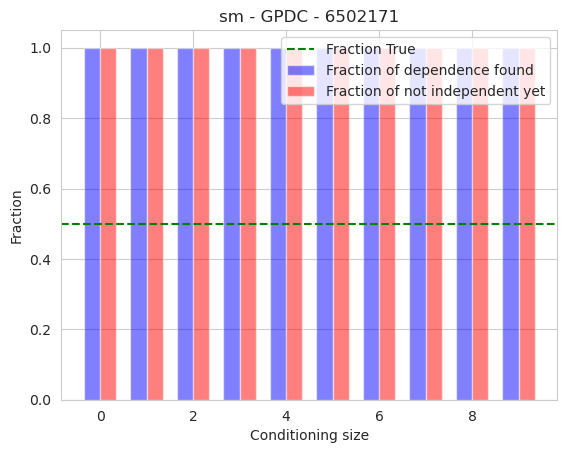

In [120]:
wide_fraction_of_ones.columns[0:]

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64', name='cond_size')

In [105]:

wide_fraction_true_df

,0
fraction_true,0.5


In [106]:
wide_fraction_of_ones

cond_size,0,1,2,3,4,5,6,7,8,9
0,1.0,1.0,0.875,1.0,0.875,0.5,0.75,0.625,0.75,0.625


In [107]:
wide_cond_ind_has_zero

cond_size,0,1,2,3,4,5,6,7,8,9
0,1.0,1.0,0.875,0.875,0.875,0.5,0.375,0.25,0.25,0.25


In [93]:
wide_fraction_of_ones = fraction_of_ones.drop('id', axis=1).set_index('cond_size').T
wide_fraction_of_ones.reset_index(drop=True, inplace=True)
wide_fraction_of_ones

cond_size,0,1,2,3,4,5,6,7,8,9
0,1.0,1.0,0.875,1.0,0.875,0.5,0.75,0.625,0.75,0.625


In [40]:

test_name = 'GPDC'
results = results_GPDC

Text(0.5, 1.0, 'GPDC - pre4')

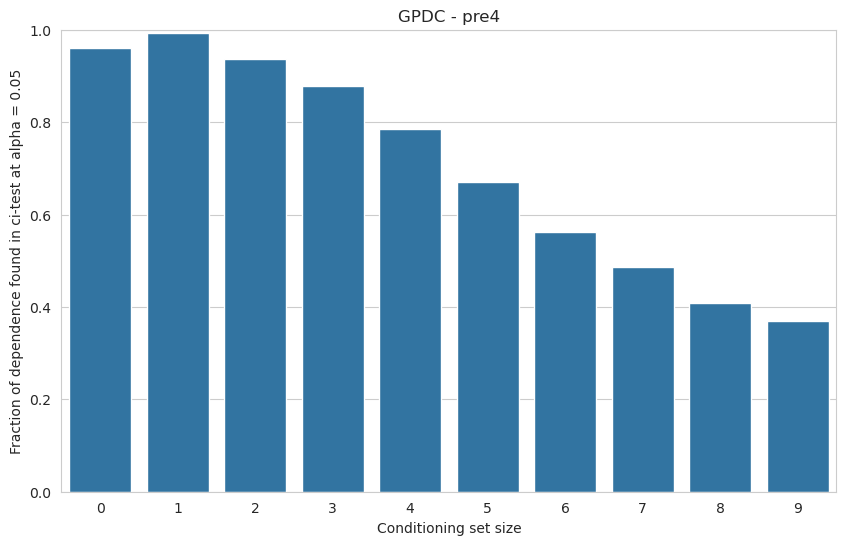

In [41]:
# Calculate the fraction of 1s for each cond_size
fraction_of_ones = results.groupby('cond_size')['dependent'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='cond_size', y='dependent', data=fraction_of_ones)

# Add labels and title
plt.xlabel('Conditioning set size')
plt.ylim(0,1)
plt.ylabel('Fraction of dependence found in ci-test at alpha = 0.05')
plt.title(f'{test_name} - {edge_of_interest}')


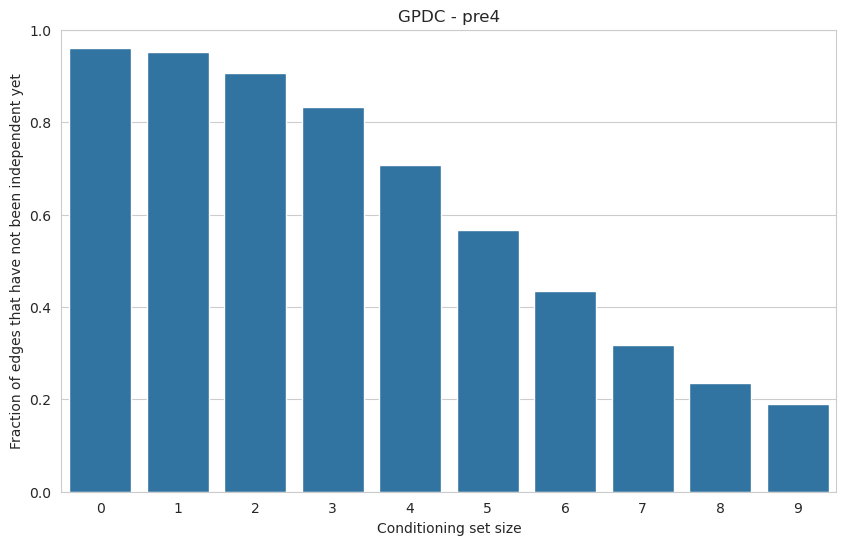

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'results' is your DataFrame
results['id_fold'] = results['id'].astype(str) + '_' + results['fold'].astype(str)
has_zero = {id_fold: False for id_fold in results['id_fold'].unique()}

# Initialize a list to store the fraction of id_fold groups that have not had dependent = 0 yet
fraction_not_zero = []

# Iterate over cond_size from 0 to 9
for cond_size in range(10):
    # Filter rows for the current cond_size
    current_rows = results[results['cond_size'] == cond_size]

    # Update the has_zero dictionary based on the current rows
    for id_fold in current_rows['id_fold'].unique():
        if not has_zero[id_fold]:
            # Check if dependent is 0 for this id_fold at this cond_size
            if current_rows[(current_rows['id_fold'] == id_fold) & (current_rows['dependent'] == 0)].shape[0] > 0:
                has_zero[id_fold] = True

    # Calculate the fraction of id_fold groups that have not had dependent = 0 yet
    fraction_not_zero.append(sum(not has_zero[id_fold] for id_fold in has_zero) / len(has_zero))

# Create a DataFrame for Seaborn
data = pd.DataFrame({
    'Conditioning set size': range(10),
    'Fraction of edges that have not been independent yet': fraction_not_zero
})

# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Conditioning set size', y='Fraction of edges that have not been independent yet', data=data)
plt.title(f'{test_name} - {edge_of_interest}')
plt.ylim(0, 1)  # Set y-axis limits to 0-1 for fraction
plt.show()


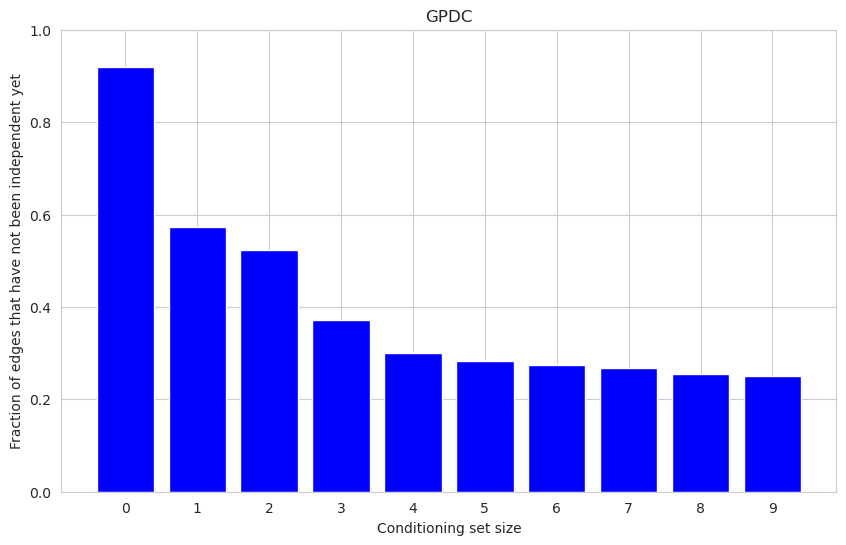

In [10]:
results['id_fold'] = results['id'].astype(str) + '_' + results['fold'].astype(str)
has_zero = {id_fold: False for id_fold in results['id_fold'].unique()}
# first_zero = results[results['dependent'] == 0].groupby('id_fold')['cond_size'].idxmin()


# Initialize a list to store the fraction of id_fold groups that have not had dependent = 0 yet
fraction_not_zero = []

# Iterate over cond_size from 0 to 9
for cond_size in range(10):
    # Filter rows for the current cond_size
    current_rows = results[results['cond_size'] == cond_size]

    # Update the has_zero dictionary based on the current rows
    for id_fold in current_rows['id_fold'].unique():
        if not has_zero[id_fold]:
            # Check if dependent is 0 for this id_fold at this cond_size
            if current_rows[(current_rows['id_fold'] == id_fold) & (current_rows['dependent'] == 0)].shape[0] > 0:
                has_zero[id_fold] = True

    # Calculate the fraction of id_fold groups that have not had dependent = 0 yet
    fraction_not_zero.append(sum(not has_zero[id_fold] for id_fold in has_zero) / len(has_zero))

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(10), fraction_not_zero, color='blue')
plt.xlabel('Conditioning set size')
plt.ylabel('Fraction of edges that have not been independent yet')
plt.title(test_name)
plt.xticks(range(10), labels=[f'{i}' for i in range(10)])
plt.ylim(0, 1)  # Set y-axis limits to 0-1 for fraction
plt.show()


# Old Misc

In [ ]:
test_statistics, p_values, dependents = [],[],[]
# for id in ids:
id = ids[1]
max_folds = 3

context = 'resampled'
ic(id)
alpha = 0.05
data = all_data[context][id]
peaks = all_peaks[context][id]
folds_peak = split_list_into_subsets(
                    data=peaks,
                    num_subsets=max_folds,
                    subset_size=1000,
                    random_seed=1337,
                )

X = [(q,0)]
Y = [(sm,-7)]
basin_results = pd.DataFrame()
for fold_index in range(max_folds):
    # folds_peak[fold_index]
    mask = mask_builder(data= data, indices=folds_peak[fold_index])


    var_name_index = {col: idx for idx, col in enumerate(data.columns)}
    dataframe = pp.DataFrame(data.to_numpy(), var_names=data.columns.to_list(), mask = mask)
    cond_ind_test = ParCorr()
    cond_ind_test.set_dataframe(dataframe)
    cond_ind_test.set_mask_type('y')

    parents_of_q = list(get_link_assumptions()[4].keys())


    results_fold = run_increasing_order_cond_ind_tests(cond_ind_test=cond_ind_test,
                                        X = X,
                                        Y = Y,
                                        all_parents=parents_of_q,
                                        alpha=alpha)
    results_fold['fold'] = fold_index
    basin_results = pd.concat([basin_results, results_fold], ignore_index=True)

basin_results

ic| id: 6502171


/tmp/ipykernel_3749747/2295613524.py:55: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)
/tmp/ipykernel_3749747/2295613524.py:55: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)
/tmp/ipykernel_3749747/2295613524.py:55: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)
/tmp/ipykernel_3749747/2295613524.py:55: FutureWarning: In a future version, object-dtype columns with all-bool values wi

,cond_size,cond_set,test_statistic,p_value,dependent,fold
0,1,"[(4, -1)]",-0.018119,5.673184e-01,False,0
1,2,"[(4, -1), (1, 0)]",-0.014864,6.390527e-01,False,0
2,3,"[(4, -1), (1, 0), (0, -2)]",-0.035851,2.580826e-01,False,0
3,4,"[(4, -1), (1, 0), (0, -2), (0, -1)]",0.210441,1.968531e-11,True,0
4,5,"[(4, -1), (1, 0), (0, -2), (0, -1), (0, -3)]",0.216582,5.009372e-12,True,0
5,6,"[(4, -1), (1, 0), (0, -2), (0, -1), (0, -3), (...",0.214347,8.556149e-12,True,0
6,7,"[(4, -1), (1, 0), (0, -2), (0, -1), (0, -3), (...",0.208430,3.295266e-11,True,0
7,8,"[(4, -1), (1, 0), (0, -2), (0, -1), (0, -3), (...",0.199177,2.469289e-10,True,0
8,9,"[(4, -1), (1, 0), (0, -2), (0, -1), (0, -3), (...",0.218323,3.700736e-12,True,0
9,1,"[(4, -1)]",-0.038314,2.263116e-01,False,1


In [42]:

context = 'resampled'
id = ids[1]
ic(id)
alpha = 0.05
data = all_data[context][id]
peaks = all_peaks[context][id]
folds_peak = split_list_into_subsets(
                    data=peaks,
                    num_subsets=5,
                    subset_size=1000,
                    random_seed=1337,
                )

X = [(q,0)]
Y = [(sm,-7)]

fold_index = 0
# folds_peak[fold_index]
mask = mask_builder(data= data, indices=folds_peak[fold_index])


var_name_index = {col: idx for idx, col in enumerate(data.columns)}
dataframe = pp.DataFrame(data.to_numpy(), var_names=data.columns.to_list(), mask = mask)
cond_ind_test = ParCorr()
cond_ind_test.set_dataframe(dataframe)
cond_ind_test.set_mask_type('y')

parents_of_q = list(get_link_assumptions()[4].keys())

# get the parents of X ordered by the test statistic absolute value
statistical_test_ordered_list = get_statistics_unconditional_independence(cond_ind_test=cond_ind_test, X = [(q,0)], Ys = parents_of_q, alpha=alpha)

# make ordered list of parents except Y
parents_of_q_ordered_list = [l[0] for l in statistical_test_ordered_list if l[0] != Y[0]]
parents_of_q_ordered_list

cond_ind_results = run_all_cond_ind_tests(cond_ind_test=cond_ind_test, X=X,Y=Y, all_parents=parents_of_q_ordered_list, alpha=alpha)




ic| id: 6502171


In [43]:

cond_ind_results.sort(key=lambda x: x[2], reverse=True)
cond_ind_results

[([(4, -1), (1, 0), (0, 0), (2, -7)],
  -0.013798595546004122,
  0.663598583161803,
  False),
 ([(4, -1), (1, 0), (0, 0)], -0.013825518278060405, 0.6628235387287309, False),
 ([(4, -1), (1, 0), (2, -7)],
  -0.014865847499064819,
  0.6391906153018104,
  False),
 ([(4, -1), (1, 0)], -0.014864496036180803, 0.6390526535118746, False),
 ([(4, -1), (0, 0)], -0.017331331248228284, 0.5844670937794034, False),
 ([(4, -1), (0, 0), (2, -7)], -0.01737102468620594, 0.583795802515589, False),
 ([(4, -1)], -0.018118643877369292, 0.5673184143819625, False),
 ([(4, -1), (2, -7)], -0.018167631501672145, 0.5664658258199724, False),
 ([(4, -1), (1, 0), (0, -6), (0, 0), (2, -7)],
  -0.022406027224986195,
  0.48020838966945645,
  False),
 ([(4, -1), (1, 0), (0, -6), (0, 0)],
  -0.022492927187472974,
  0.47828531771842875,
  False),
 ([(4, -1), (1, 0), (0, -6), (2, -7)],
  -0.023481004079401357,
  0.4591668305742851,
  False),
 ([(4, -1), (1, 0), (0, -6)],
  -0.023542515883098573,
  0.4577647454106252,
  Fal

<Axes: xlabel='size', ylabel='pval'>

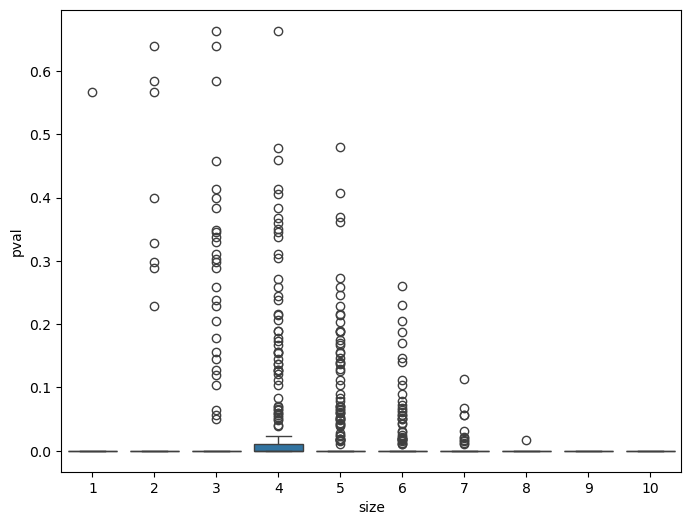

In [53]:
cond_ind_results_for_plotting = [(len(l[0]),l[2]if l[2]>0.01 else 0) for l in cond_ind_results]

df = pd.DataFrame(cond_ind_results_for_plotting, columns=["size", "pval"])

plt.figure(figsize=(8, 6))
sns.boxplot(x="size", y="pval", data=df)
# plt.yscale("log")

In [44]:
run_single_cond_ind_test(cond_ind_test, X,Y,Z= parents_of_q_ordered_list, alpha=alpha)

(0.22253863108472866, 1.4192415433985157e-12, True)

In [31]:



# Define the variables to test
X = [(q,0)]
Y = [(sm,-7)]
# Define the conditioning set
# Z = [(pre, 0),
#      (pre, -1),
#      (pre, -2),
#      (pre, -3),
#      (pre, -4),
#      (pre, -5),
#      (pre, -6),
#      (pre, 0),
#      ]
Z = None


p_value = run_single_cond_ind_test(cond_ind_test, X,Y,Z)
print(f"P-value: {p_value}| Reject independence at alpha = {alpha}: {p_value <alpha}")

ic| id: 6502171


ValueError: The list does not have enough elements to create the specified number of subsets.

In [31]:
var_name_index

{'tavg': 0, 'pre': 1, 'snow': 2, 'SM': 3, 'Q': 4}

In [5]:
import numpy as np

from causal_discovery_tools import get_link_assumptions, split_list_into_subsets, mask_builder
# from tigramite.independence_tests.gpdc_torch import GPDCtorch

alpha = 0.05


# Example data: 3 variables, 100 time steps
data = np.random.randn(100, 3)
# Create a Tigramite DataFrame
dataframe = pp.DataFrame(data, var_names=['A', 'B', 'C'])

# set data
# Initialize the conditional independence test
cond_ind_test = ParCorr()
cond_ind_test.set_dataframe(dataframe)
# cond_ind_test.set_mask_type('y')

# Define the variables to test
var1 = [(0,0)]
var2 = [(1,0)]
# Define the conditioning set
# conditioning_set = [(2, 0)]
conditioning_set = None

# Perform the conditional independence test
# returns test statistic value and the p-value
test_statistic, p_value = cond_ind_test.run_test(
    X=var1, 
    Y=var2,
    Z=conditioning_set
)

print(f"P-value: {p_value}| Reject independence at alpha = {alpha}: {p_value <alpha}")

P-value: 0.7380293245775773| Reject independence at alpha = 0.05: False


In [41]:
parcorr = ParCorr()

pcmci= PCMCI(
    dataframe=dataframe,
    cond_ind_test=parcorr,
    verbosity=0
)

# To manually perform a conditional independence test
# between X and Y with time lag tau, conditioned on Z
val, pval = pcmci.cond_ind_test(
    X=0,              # Index of first variable
    Y=1,              # Index of second variable
    Z=[[2, -1]],     # Conditioning set with format [[var_index, lag], ...]
    tau_max=2,       # Maximum time lag
    tau=1            # Time lag between X and Y
)

TypeError: 'ParCorr' object is not callable